In [1]:
import os
import sys
sys.path.append('../../hetnet-ml/src')
import graph_tools as gt
import pickle
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
nodes = pd.read_csv('../data/nodes_VER31_R_consolidated_condensed.csv')
edges = pd.read_csv('../data/edges_VER31_R_consolidated_condensed.csv')

# remove : character from column names to make them queryable
nodes = gt.remove_colons(nodes)
edges = gt.remove_colons(edges)

In [3]:
comps = (nodes['label'] == 'Chemicals & Drugs').sum() 
diseases = (nodes['label'] == 'Disorders').sum()

print('{:,} Compounds x {:,} Diseases = {:,} C-D pairs'.format(comps, diseases, comps*diseases))

79,223 Compounds x 34,325 Diseases = 2,719,329,475 C-D pairs


In [4]:
nodes.head(2)

,id,name,label,id_source
0,C0418940,Change of employment,Activities & Behaviors,UMLS
1,D006686,Hobbies,Activities & Behaviors,MeSH


In [5]:
edges.head(2)

,start_id,end_id,type,pmids,n_pmids
0,D012648,D000368,ADMINISTERED_TO_ABatLB,"{25811968, 27904100, 2816907, 21197917, 220705...",8
1,D012648,D012424,ADMINISTERED_TO_ABatLB,{15779248},1


In [6]:
counts = edges["type"].value_counts()
counts

LOCATION_OF_AloCD            976627
INTERACTS_WITH_CDiwG         685425
LOCATION_OF_AloG             530568
TREATS_CDtDO                 523202
ASSOCIATED_WITH_DOawDO       465285
LOCATION_OF_AloDO            458458
PRODUCES_LBpdCD              454085
STIMULATES_CDstCD            441310
AFFECTS_DOafLB               429212
STIMULATES_CDstG             377490
TREATS_PRtDO                 345634
AFFECTS_CDafA                317921
ASSOCIATED_WITH_GawDO        259812
AFFECTS_GafPS                250153
USES_PRuCD                   249391
INHIBITS_GinCD               241332
LOCATION_OF_AloA             227011
AUGMENTS_CDagPS              226235
PART_OF_GpoLB                216165
INTERACTS_WITH_GiwG          204609
RELATED_TO_CDrtCD            185882
DISRUPTS_CDdsPS              185374
DIAGNOSES_PRdgDO             184370
METHOD_OF_PRmoPR             160305
OCCURS_IN_AoiLB              133191
AUGMENTS_GagDO               130390
AFFECTS_GafA                 129183
PROCESS_OF_PSproLB          

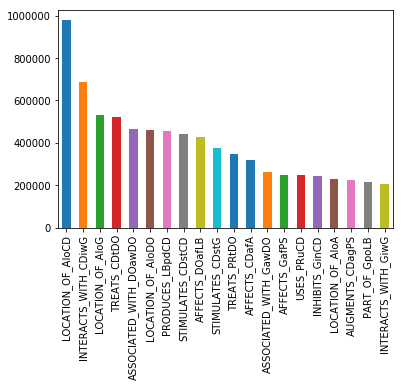

In [7]:
counts[:20].plot(kind='bar');

# Filter out the lower count edge types

In [8]:
'{:,}'.format(edges.shape[0])

'11,504,961'

In [9]:
cutoff = .001

print("Number of edge types with this cutoff: {}".format((counts > cutoff*len(edges)).sum()))
print("Number of edges that remain with this cutoff: {:,}".format(counts[counts > cutoff*len(edges)].sum()))

Number of edge types with this cutoff: 66
Number of edges that remain with this cutoff: 10,739,876


In [10]:
ok_edges = list(counts[counts > cutoff*len(edges)].index)

In [11]:
result = edges.query('type in @ok_edges')

In [12]:
'{:,}'.format(result.shape[0])

'10,739,876'

# Some quick validation that all ids are the same between nodes and edges

In [13]:
edge_ids = set(result['start_id'].unique()).union(set(result['end_id'].unique()))

In [14]:
node_ids = set(nodes['id'].unique())

In [15]:
not_in_edges = node_ids - edge_ids

In [16]:
not_in_edges = list(not_in_edges)

In [17]:
idx = nodes.query('id in @not_in_edges').index
nodes.loc[idx]

,id,name,label,id_source
0,C0418940,Change of employment,Activities & Behaviors,UMLS
1,D006686,Hobbies,Activities & Behaviors,MeSH
2,D003659,"Decision Making, Organizational",Activities & Behaviors,MeSH
3,C0680834,program planning,Activities & Behaviors,UMLS
6,C0260207,Rest periods,Activities & Behaviors,UMLS
7,D006749,Hospital Design and Construction,Activities & Behaviors,MeSH
10,D016139,Martial Arts,Activities & Behaviors,MeSH
11,C0558125,Monogamous,Activities & Behaviors,UMLS
14,C0871507,Test Construction,Activities & Behaviors,UMLS
17,C0597915,computer pattern recognition,Activities & Behaviors,UMLS


In [18]:
nodes = nodes.drop(idx)

In [19]:
len(nodes)

199572

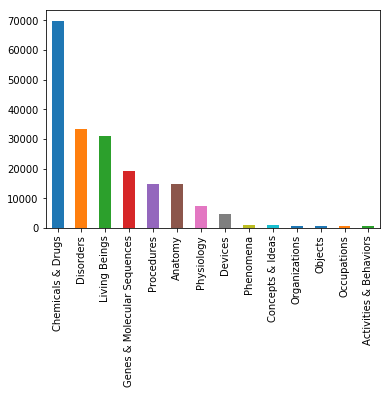

In [20]:
nodes['label'].value_counts().plot(kind='bar');

# Look at the resulting network to see if other changes are necessary

In [21]:
combo = gt.combine_nodes_and_edges(gt.add_colons(nodes), gt.add_colons(result[['start_id', 'end_id', 'type', 'n_pmids']]))
combo = gt.remove_colons(combo)

In [22]:
combo.head(2)

,start_id,end_id,type,n_pmids,start_name,end_name,start_label,end_label
446,C1179920,C0680063,ADMINISTERED_TO_CDatLB,2,Nuclear deoxyribonucleic acid,Offspring,Chemicals & Drugs,Living Beings
447,D011163,D008251,ADMINISTERED_TO_CDatLB,1,Hydroxymethylbilane Synthase,Macaca,Chemicals & Drugs,Living Beings


In [23]:
max_edge = combo["n_pmids"].max()
combo.query('n_pmids == @max_edge')

,start_id,end_id,type,n_pmids,start_name,end_name,start_label,end_label
1875902,D010051,D010051,ASSOCIATED_WITH_DOawDO,68380,Ovarian Neoplasms,Ovarian Neoplasms,Disorders,Disorders


In [24]:
frame = pd.DataFrame()
for i in range(10):

    to_plot = combo.query('n_pmids > @i')['type'].value_counts()
    to_plot = to_plot / to_plot.sum()
    frame[i+1] = to_plot

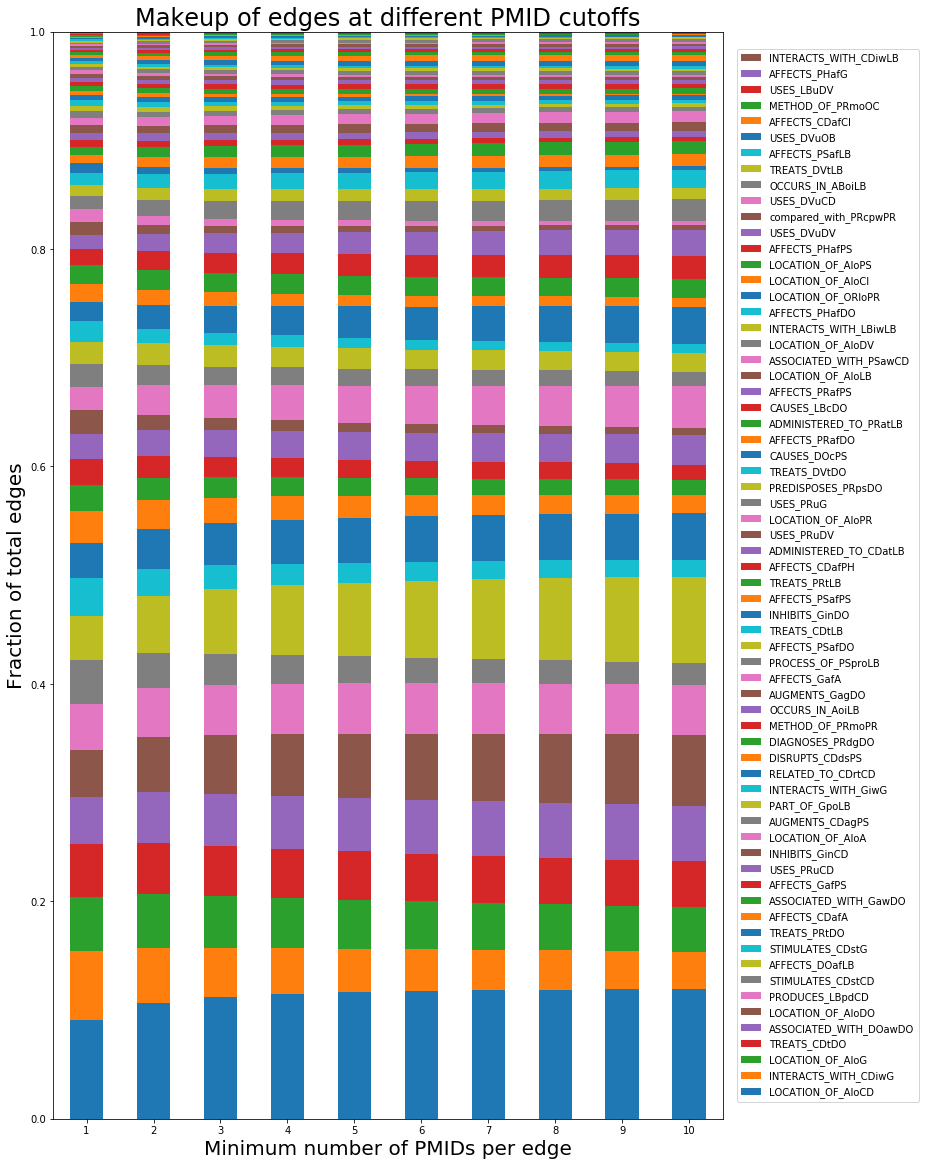

In [25]:
fig = frame.T.plot.bar(stacked=True, figsize=(12, 20))
handels, labels = fig.axes.get_legend_handles_labels()
plt.legend(handels[::-1], labels[::-1], loc=7, bbox_to_anchor=(1.3, 0.5))
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.title('Makeup of edges at different PMID cutoffs', size=24)
plt.xlabel('Minimum number of PMIDs per edge', size=20)
plt.ylabel('Fraction of total edges', size = 20);

In [26]:
combo.sort_values('n_pmids', ascending=False)[['n_pmids', 'start_name', 'type', 'end_name']].iloc[:60]

,n_pmids,start_name,type,end_name
1875902,68380,Ovarian Neoplasms,ASSOCIATED_WITH_DOawDO,Ovarian Neoplasms
7670507,46560,Brain,OCCURS_IN_AoiLB,Rats
7697647,46527,Liver,OCCURS_IN_AoiLB,Rats
933522,36514,Ovarian Neoplasms,AFFECTS_DOafLB,Child
11300524,34650,Clinical Study,USES_PRuDV,Study models
6065449,31926,Tissues,LOCATION_OF_AloDO,Ovarian Neoplasms
936461,27306,Ovarian Neoplasms,AFFECTS_DOafLB,Mice
790811,26719,Breast Neoplasms,AFFECTS_DOafLB,Women
5342018,24634,Serum,LOCATION_OF_AloCD,Creatinine
5849841,22235,Plasma,LOCATION_OF_AloCD,Glucose


In [27]:
combo.query('start_id == end_id')['type'].value_counts()

RELATED_TO_CDrtCD         3757
INTERACTS_WITH_GiwG       3621
compared_with_PRcpwPR     1769
ASSOCIATED_WITH_DOawDO     942
STIMULATES_CDstCD          396
METHOD_OF_PRmoPR           241
INTERACTS_WITH_LBiwLB      165
LOCATION_OF_AloA           161
AFFECTS_PSafPS              83
USES_DVuDV                  35
Name: type, dtype: int64

There are some instances of self-referrential edges.  These should be removed as they are not vaild in DWPC feature extraction.

In [28]:
result = gt.remove_colons(result)
idx = result.query('start_id == end_id').index
result = result.drop(idx)

In [29]:
node_degrees = pd.concat([combo['start_name'], combo['end_name']]).value_counts()

In [30]:
node_degrees[:60]

Ovarian Neoplasms                 44346
Mice                              44054
Rats                              43875
Child                             35881
Women                             30756
Tissues                           30087
Growth                            26297
Brain                             25935
Adult                             24774
Liver                             24669
Men                               22228
Cell Line                         22096
Dogs                              21175
Apoptosis                         20391
Surgical Procedures, Operative    19889
Family                            19110
Rabbits                           18367
Infant                            18262
Neurons                           17984
Wounds and Injuries               17365
Lung                              17354
Cytoplasm                         17230
Blood                             17017
Heart                             16518
Control Groups                    16246


Even though in a previous notebook, some of the General terms were filtered out... there are still plenty of terms that appear to be too general to be useful.  From the top 100 of these, we will filter many of them out.

In [31]:
#These are from the 100 most common nodes, removing things that are too general to be usefl

too_general = ['Patients', 'Cells', 'Syndrome', 'Therapeutics', 'Proteins', 'Pharmaceutical Preparations',
 'Mice', 'Human', 'Child', 'Genes', 'Woman', 'Tissues', 'Ovarian Neoplasms', 'Growth', 'Individual', 'Antibodies',
 'Surgical Procedures, Operative', 'Adult', 'Enzymes', 'Symptoms', 'Animals', 'Cell Line', 'Wounds and Injuries', 'Complication',
 'House mice', 'Functional disorder', 'Infant', 'Family', 'Persons', 'Male population group', 'Monoclonal Antibodies',
 'Toxic effect', 'Infection', 'DNA', 'Control Groups', 'Injection procedure', 'Ions', 'Transcription, Genetic',
 'Organ', 'TRANSCRIPTION FACTOR', 'cohort']

In [32]:
idx = nodes.query('name in @too_general').index
nodes = nodes.drop(idx).reset_index(drop=True)

In [33]:
node_ids = nodes['id'].unique()

In [34]:
result = result.query('start_id in @node_ids and end_id in @node_ids')

In [35]:
'{:,} Edges remain'.format(len(result))

'10,310,300 Edges remain'

In [36]:
counts = (result[result['n_pmids'] < 21]['n_pmids'].value_counts()
                                                   .rename('counts')
                                                   .to_frame()
                                                   .reset_index()
                                                   .rename(columns={'index':'n_pmids'}))

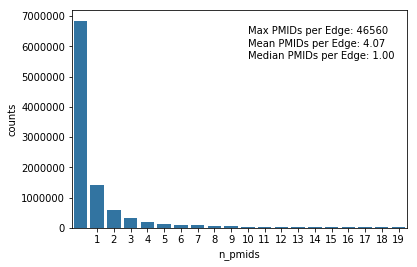

In [37]:
sns.barplot(x='n_pmids', y='counts', data=counts, color=sns.color_palette()[0])
plt.xticks(np.arange(1, 20, 1))
plt.text(10, 0.64e7, 'Max PMIDs per Edge: {}'.format(result['n_pmids'].max()))
plt.text(10, 0.60e7, 'Mean PMIDs per Edge: {:1.2f}'.format(result['n_pmids'].mean()))
plt.text(10, 0.56e7, 'Median PMIDs per Edge: {:1.2f}'.format(result['n_pmids'].median()));

In [38]:
for i in range(1, 11):
    print("Edges with at least {} unique PMIDs: {:,}".format(i, (result['n_pmids'] >= i).sum()))

Edges with at least 1 unique PMIDs: 10,310,300
Edges with at least 2 unique PMIDs: 3,467,931
Edges with at least 3 unique PMIDs: 2,061,296
Edges with at least 4 unique PMIDs: 1,468,332
Edges with at least 5 unique PMIDs: 1,140,377
Edges with at least 6 unique PMIDs: 931,353
Edges with at least 7 unique PMIDs: 787,068
Edges with at least 8 unique PMIDs: 681,285
Edges with at least 9 unique PMIDs: 599,493
Edges with at least 10 unique PMIDs: 535,259


In [39]:
result = gt.add_colons(result)
nodes = gt.add_colons(nodes)

result.to_csv('../data/edges_VER31_R_consolidated_condensed_filtered_001.csv', index=False)
nodes.to_csv('../data/nodes_VER31_R_consolidated_condensed_filtered_001.csv', index=False)